In [19]:
import json
import numpy as np
import pickle as pkl
from matplotlib import pyplot as plt

In [20]:
logfn = '/home/dev/PycharmProjects/distopia_task_switcher/distopia/distopia/logs/distopia_log_2019-08-27 13.13.09.670578.json'
standardization_f = '/home/dev/PycharmProjects/distopia_agents/agents/resources/stripped_normalization.pkl'

In [ ]:
with open(logfn) as logfile:
    logs = json.load(logfile)

In [6]:
def get_metric(metric_arr,key):
    for metric in metric_arr:
        if metric['name'] == key:
            return metric
    return None

In [7]:
 metric_extractors = {

        #overall normalization plan: run one-hots in either direction to get rough bounds
        # then z-normalize and trim on edges
        #'population' : lambda s,d : s.scalar_std,
        # standard deviation of each district's total populations (-1)
        # normalization: [0, single_district std] 
        'population' : lambda s,d : np.std([get_metric(dm['metrics'],'population')['scalar_value'] for dm in d]),
        # mean of district margin of victories (-1)
        # normalization: [0,1]
        'pvi' : lambda s,d : s['scalar_maximum'],
        # minimum compactness among districts (maximize the minimum compactness, penalize non-compactness) (+1)
        # normalization: [0,1]
        'compactness' : lambda s,d : np.min([get_metric(dm['metrics'],'compactness')['scalar_value'] for dm in d]),
        # mean ratio of democrats over all voters in each district (could go either way)
        # normalization: [0,1]
        'projected_votes' : lambda s,d : np.mean([get_metric(dm['metrics'],'projected_votes')['scalar_value']/ \
                                                  get_metric(dm['metrics'],'projected_votes')['scalar_maximum'] \
                                                  for dm in d]),
        # std of ratio of nonminority to minority over districts
        # normalization: [0, ]
        'race' : lambda s,d : np.std([get_metric(dm['metrics'],'race')['scalar_value']/get_metric(dm['metrics'],'race')['scalar_maximum'] for dm in d]),
        # scalar value is std of counties within each district. we take a max (-1) to minimize variance within district (communities of interest)
        # 'income' : lambda s,d : np.max([dm.metrics['income'].scalar_value for dm in d]),
        # #'education' : lambda s,d : s.scalar_std,
        # 
        # # maximum sized district (-1) to minimize difficulty of access
        # # normalization [0,size of wisconsin]
        # 'area' : lambda s,d: s.scalar_maximum
    }

In [15]:
def parse_metrics_obj(districts_obj,desired_keys):
    extracted_metrics = []
    # make sure these keys are in the right order!!
    districts = districts_obj['districts']
    for key in desired_keys:
        val = metric_extractors[key](get_metric(districts_obj['metrics'],key),districts)
        extracted_metrics.append(val)
    return extracted_metrics
        

In [31]:
metric_order = ['population','pvi','compactness', 'projected_votes', 'race']
trajectories = [] # tuple of trajectory, focus_trajectory, and label
cur_task = None
cur_focus = "None"
cur_trajectory = []
cur_focus_trajectory = []
task_counter = 0
for log in logs:
    keys = log.keys()
    if "task" in keys:
            trajectories.append((cur_trajectory[:],cur_focus_trajectory[:],cur_task))
            cur_task = log["task"]
            cur_trajectory = []
            cur_focus_trajectory = []
            task_counter += 1
    elif cur_task is None:
        continue
    else:
        if "focus" in keys and log['focus']['cmd'] == 'focus_state':
            cur_focus = log['focus']['param']
        elif "districts" in keys:
            cur_trajectory.append(parse_metrics_obj(log['districts'],metric_order))
            cur_focus_trajectory.append(cur_focus)
trajectories.append((cur_trajectory[:],cur_focus_trajectory[:],cur_task))
            

In [22]:
# load the standardization params\n",
with open(standardization_f,'rb') as sfile:
    standard_m, standard_std = pkl.load(sfile)
def metric_standardize(data, m, std):
    data = np.array(data)
    return (data - m)/std

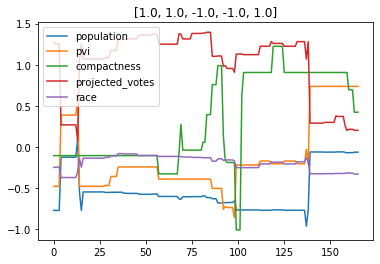

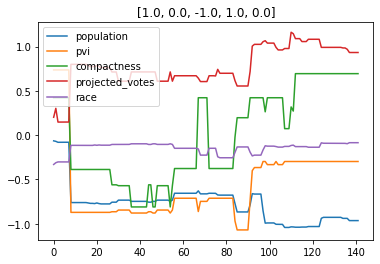

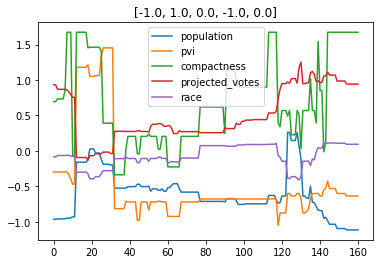

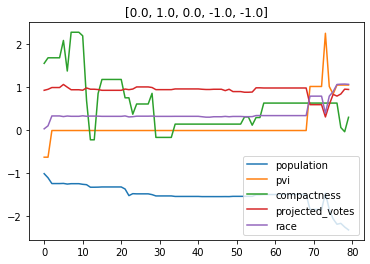

In [32]:
for trajectory in trajectories:
    metric_list,focus_list,task = trajectory
    if len(metric_list) == 0:
        continue
    else:
        standardized = metric_standardize(metric_list,standard_m,standard_std)
        for i in range(standardized.shape[1]):
            plt.plot(standardized[:,i],label=metric_order[i])
    plt.title(str(task))
    plt.legend(loc=0)
    plt.show()
